In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point


In [3]:

file_path = '/content/data.xlsx'  # Replace with your file path
data = pd.read_excel(file_path)

print(data.columns)

drought_data = data[['Year', 'Month', 'SPI', 'TCI', 'VCI', 'X', 'Y']]
drought_data = drought_data.dropna()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(drought_data[['SPI', 'TCI', 'VCI']])

scaled_data = pd.DataFrame(scaled_data, columns=['SPI', 'TCI', 'VCI'])
scaled_data['Year'] = drought_data['Year'].values
scaled_data['Month'] = drought_data['Month'].values
scaled_data['X'] = drought_data['X'].values
scaled_data['Y'] = drought_data['Y'].values

print(scaled_data.head())

Index(['Year', 'Month', 'X', 'Y', 'SPI', 'VCI', 'TCI'], dtype='object')
        SPI       TCI       VCI  Year  Month      X      Y
0  0.762520  0.503762  0.993179  1991      5  69.75  26.75
1  0.746793  0.337004  0.991847  1991      6  69.75  26.75
2  0.694330  0.102845  0.989258  1991      7  69.75  26.75
3  0.636796  0.072416  0.986850  1991      8  69.75  26.75
4  0.615581  0.084167  0.985424  1991      9  69.75  26.75


In [4]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length][['SPI', 'TCI', 'VCI']].values
        label = data.iloc[i + seq_length][['SPI', 'TCI', 'VCI']].values
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)
seq_length = 12

X, y = create_sequences(scaled_data, seq_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

spatial_data = scaled_data.iloc[seq_length:]
spatial_train = spatial_data.iloc[:split]
spatial_test = spatial_data.iloc[split:]

print(f'Training shape: {X_train.shape}, {y_train.shape}')
print(f'Testing shape: {X_test.shape}, {y_test.shape}')


Training shape: (6590, 12, 3), (6590, 3)
Testing shape: (1648, 12, 3), (1648, 3)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12, 100)           41600     
                                                                 
 dropout_6 (Dropout)         (None, 12, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 303       
                                                                 
Total params: 122303 (477.75 KB)
Trainable params: 122303 (477.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/2

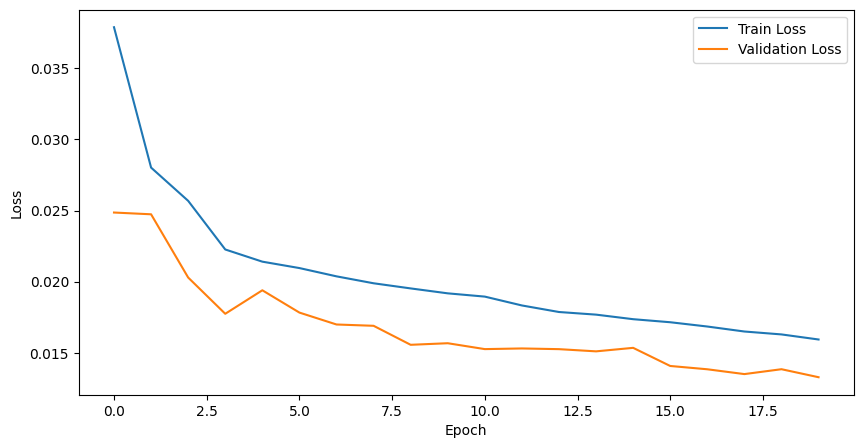

In [14]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate evaluation metrics
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))
train_r2 = r2_score(y_train_actual, train_predict)
test_r2 = r2_score(y_test_actual, test_predict)

print(f'Train MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}')
print(f'Test MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}')


52/52 [==============================] - 0s 4ms/step
Train MAE: 49.7201, RMSE: 255.2006, R2: 0.2826
Test MAE: 48.0186, RMSE: 176.8846, R2: 0.2178


In [17]:
# Predict future values
future_steps = 12
last_sequence = X_test[-1]

future_predictions = []
for _ in range(future_steps):
    next_pred = model.predict(last_sequence[np.newaxis, :, :])[0]
    future_predictions.append(next_pred)
    last_sequence = np.vstack([last_sequence[1:], next_pred])

# Inverse transform future predictions
future_predictions = scaler.inverse_transform(future_predictions)

# Print future predictions
print("Future Predictions:")
print(future_predictions)


1/1 [==============================] - 0s 19ms/step
Future Predictions:
[[ -0.2936593   38.24256755 106.32708378]
 [ -0.18513594  41.69822549 125.34093416]
 [ -0.19738231  48.23899975 121.72784662]
 [ -0.28553376  43.32468372 103.63277103]
 [ -0.4408678   32.54680839 100.05661687]
 [ -0.67075078  28.09596029  88.85896369]
 [ -0.88089568  32.36615909  69.52775984]
 [ -0.86546751  41.24886387  71.2695562 ]
 [ -0.60877467  44.0147759   89.31265149]
 [ -0.39748112  41.24406298 103.09336132]
 [ -0.29036348  38.90774129 110.73537888]
 [ -0.27436594  39.41045544 108.51481649]]


Point with the most droughts: POINT (72 26.5) with 118 drought months
Months with the most droughts:
    Year  Month  Drought
4   1991      9       11
85  2008      5       11
88  2008      8       11
57  2002      7       11
58  2002      8       11
59  2002      9       11
60  2003      5       11
74  2005      9       11
21  1995      6       11
22  1995      7       11
Drought durations:
        X      Y  DroughtDuration
0   71.50  27.75              105
1   71.75  26.50              100
2   71.75  26.75               99
3   71.75  27.00              106
4   71.75  27.25               97
5   71.75  27.50              117
6   71.75  27.75               93
7   72.00  26.50              118
8   72.00  26.75               99
9   72.00  27.00               96
10  72.00  27.75              105


<ipython-input-19-82eef649f70e>:34: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


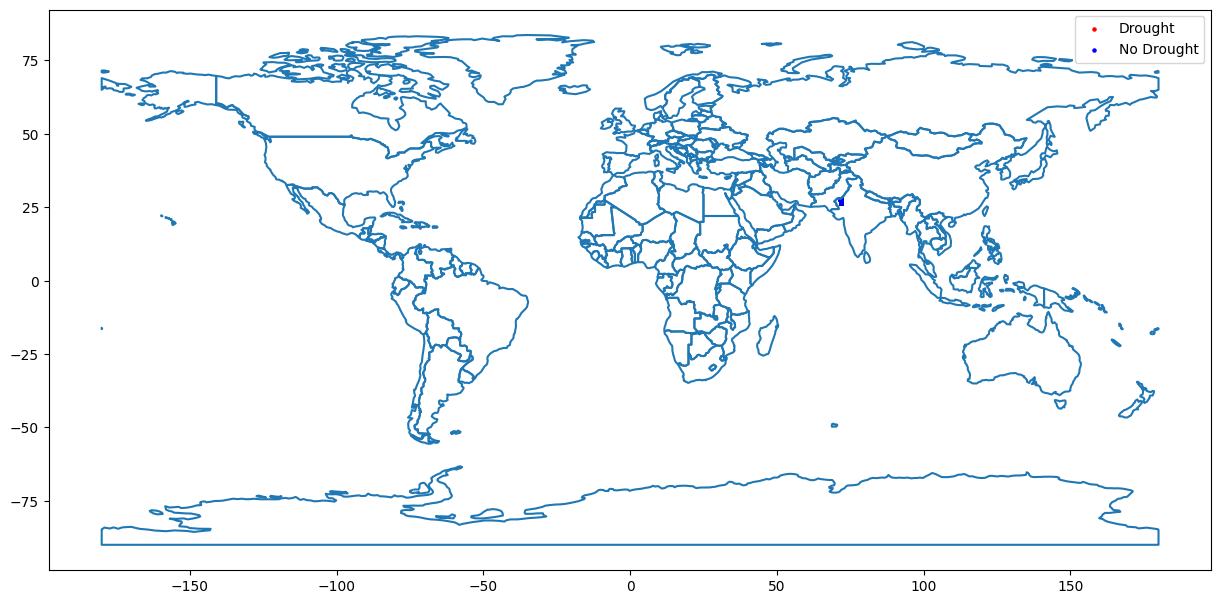

In [19]:
# Convert predictions to DataFrame for spatial analysis
predicted_df = pd.DataFrame(test_predict, columns=['SPI', 'TCI', 'VCI'])
predicted_df['Year'] = spatial_test['Year'].values
predicted_df['Month'] = spatial_test['Month'].values
predicted_df['X'] = spatial_test['X'].values
predicted_df['Y'] = spatial_test['Y'].values

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(predicted_df['X'], predicted_df['Y'])]
geo_pred_df = gpd.GeoDataFrame(predicted_df, geometry=geometry)

# Define drought conditions
geo_pred_df['Drought'] = (geo_pred_df['SPI'] < -1.0) | (geo_pred_df['TCI'] < 40) | (geo_pred_df['VCI'] < 40)

# Aggregate data to find points with the most droughts
drought_counts = geo_pred_df.groupby('geometry')['Drought'].sum().reset_index()
drought_counts = drought_counts.sort_values(by='Drought', ascending=False)

# Find the point with the most droughts
most_droughts_point = drought_counts.iloc[0]
print(f"Point with the most droughts: {most_droughts_point['geometry']} with {most_droughts_point['Drought']} drought months")

monthly_droughts = geo_pred_df.groupby(['Year', 'Month'])['Drought'].sum().reset_index()
monthly_droughts = monthly_droughts.sort_values(by='Drought', ascending=False)
print("Months with the most droughts:")
print(monthly_droughts.head(10))

geo_pred_df['DroughtDuration'] = geo_pred_df.groupby(['X', 'Y'])['Drought'].cumsum()
drought_durations = geo_pred_df[geo_pred_df['Drought']].groupby(['X', 'Y'])['DroughtDuration'].max().reset_index()
print("Drought durations:")
print(drought_durations)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax)
geo_pred_df[geo_pred_df['Drought']].plot(ax=ax, marker='o', color='red', markersize=5, label='Drought')
geo_pred_df[~geo_pred_df['Drought']].plot(ax=ax, marker='o', color='blue', markersize=5, label='No Drought')
plt.legend()
plt.show()
